# Project : Toxic Comments Classification using LSTM
The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). 

So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this project, we have challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. We will be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

# Importing Essential Libraries 

In [6]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU


# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

## Reading dataset

In [2]:
train = pd.read_csv("train_toxic.csv")

In [3]:
# checking top 5 rows of the dataset
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Checking for Missing values

In [4]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


Thats great!! no missing values in the train dataset

## Checking distribution of Target Class Types

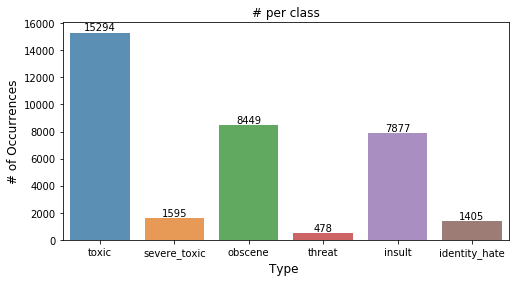

In [7]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


As we can easily observe from the above plot that dataset has maximum percentage of toxic,obscene and insult comments whereas threat has lowest percentage

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

# Checking Class Imbalance

In [10]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


Multi-tagging:
Let's check how many comments have multiple tags.

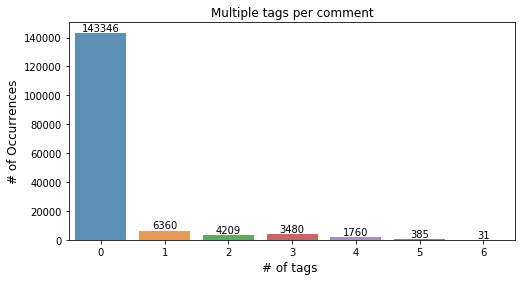

In [12]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Example Comments

In [20]:
print("Toxic comment:")
print(train[train.toxic==1].iloc[5,1])


Toxic comment:
I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82


In [19]:
print("Severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

Severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [25]:
print("Threat:")
print(train[train.threat==1].iloc[2,1])

Threat:
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you


In [26]:
print("Obscene:")
print(train[train.obscene==1].iloc[3,1])

Obscene:
GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!


In [27]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[7,1])

identity_hate:
you gay motherfucker i know where you live,i am going to sand your face off,then i am to going to beat you to a pulp,you chicken shagger.


In [2]:

# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5



In [5]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare text samples and their labels
print('Loading in comments...')


sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [7]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [10]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



Filling pre-trained embeddings...


In [11]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



In [12]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)
model.summary()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 30)           7920      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 1,008,106
Trainable params: 8,106
Non-trainable params: 1,000,000
_________________________________________________________________


In [13]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 146s 1ms/step - loss: 0.0709 - acc: 0.9765 - val_loss: 0.0578 - val_acc: 0.9799
Epoch 2/5
127656/127656 [==============================] - 145s 1ms/step - loss: 0.0552 - acc: 0.9805 - val_loss: 0.0547 - val_acc: 0.9809
Epoch 3/5
127656/127656 [==============================] - 152s 1ms/step - loss: 0.0526 - acc: 0.9811 - val_loss: 0.0537 - val_acc: 0.9807
Epoch 4/5
127656/127656 [==============================] - 143s 1ms/step - loss: 0.0515 - acc: 0.9814 - val_loss: 0.0533 - val_acc: 0.9811
Epoch 5/5
127656/127656 [==============================] - 170s 1ms/step - loss: 0.0502 - acc: 0.9817 - val_loss: 0.0538 - val_acc: 0.9810


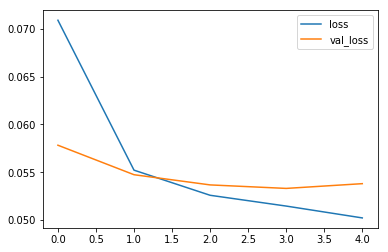

In [14]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

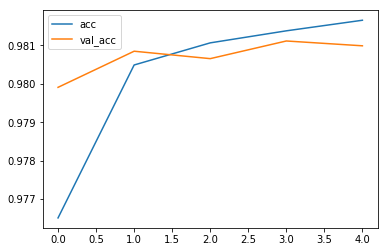

In [15]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [16]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))



0.979424494298494
